In [26]:
import pickle
import numpy as np 
import pandas as pd
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = (10,8)
mpl.rcParams["image.origin"] = 'lower'

# Data preparation
## Input: 
- E seed
- eta,phi,z seed
- E cluster
- delta_eta,delta_phi,

Filter only windows with the calo

In [117]:
data_0 = pickle.load(open("/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/four_gamma_withPU/clusters_data.pkl", "rb"))
data_1 = pickle.load(open("/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/four_gamma_withPU/clusters_data_1.pkl", "rb"))
# Take only non-seed
data_0 = data_0[data_0.is_calo & (data_0.is_seed == False)]
data_1 = data_1[data_1.is_calo & (data_1.is_seed == False)]
data  = data_0.append(data_1  )

In [120]:
data.columns

Index(['cluster_deta', 'cluster_dphi', 'cluster_iz', 'en_cluster', 'en_seed',
       'en_true', 'in_scluster', 'index', 'is_calo', 'is_seed',
       'max_dr_cluster', 'max_en_cluster', 'nclusters', 'seed_eta', 'seed_iz',
       'seed_phi', 'window_index'],
      dtype='object')

In [121]:
cols = ["seed_eta", "seed_phi", "seed_iz","cluster_deta", "cluster_dphi", "en_seed", "en_cluster"]

In [122]:
X = data[ cols ].values
truth = data[["in_scluster", "nclusters"]].values
y = np.array(truth[:,0], dtype=int)

In [123]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, QuantileTransformer
from sklearn.model_selection import train_test_split
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [125]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5)

In [126]:
from imblearn.keras import balanced_batch_generator
from imblearn.over_sampling import RandomOverSampler
training_generator, steps_per_epoch_train = balanced_batch_generator(X_train, y_train, batch_size=64, sampler=RandomOverSampler())
validation_generator, steps_per_epoch_val = balanced_batch_generator(X_val, y_val, batch_size=64, sampler=RandomOverSampler())

# Training

In [127]:
# Import all the required Libraries
import tensorflow
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.models import Model, Sequential
from keras.layers import Dense, Conv2D, Dropout, BatchNormalization, Input, Reshape, Flatten, Deconvolution2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Lambda
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import adam
from keras import backend as K

In [128]:
model = Sequential()
model.add(Dense(80, input_dim=7, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(50, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(1, activation="sigmoid"))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 80)                640       
_________________________________________________________________
dropout_12 (Dropout)         (None, 80)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 50)                4050      
_________________________________________________________________
dropout_13 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 51        
Total params: 4,741
Trainable params: 4,741
Non-trainable params: 0
_________________________________________________________________


In [130]:
history = model.fit_generator(
            training_generator, 
            epochs=20,
    initial_epoch=10,
            use_multiprocessing=True,
            steps_per_epoch=steps_per_epoch_train, 
            validation_data = validation_generator, 
            validation_steps = steps_per_epoch_val,
            workers = 3
            )

Epoch 11/20
17994/17994 [==============================] - 37s 2ms/step - loss: 0.0845 - acc: 0.9698 - val_loss: 0.0735 - val_acc: 0.9739
Epoch 12/20
17994/17994 [==============================] - 36s 2ms/step - loss: 0.0828 - acc: 0.9704 - val_loss: 0.0744 - val_acc: 0.9721
Epoch 13/20
17994/17994 [==============================] - 37s 2ms/step - loss: 0.0849 - acc: 0.9696 - val_loss: 0.0721 - val_acc: 0.9737
Epoch 14/20
17994/17994 [==============================] - 38s 2ms/step - loss: 0.0826 - acc: 0.9704 - val_loss: 0.0709 - val_acc: 0.9743
Epoch 15/20
17994/17994 [==============================] - 38s 2ms/step - loss: 0.0806 - acc: 0.9712 - val_loss: 0.0730 - val_acc: 0.9723
Epoch 16/20
17994/17994 [==============================] - 38s 2ms/step - loss: 0.0808 - acc: 0.9712 - val_loss: 0.0705 - val_acc: 0.9747
Epoch 17/20
17994/17994 [==============================] - 38s 2ms/step - loss: 0.0795 - acc: 0.9714 - val_loss: 0.0703 - val_acc: 0.9760
Epoch 18/20
17994/17994 [=========

>>> Computing AUC...
AUC score: 0.9955587877741556
>>> Saving ROC curve...


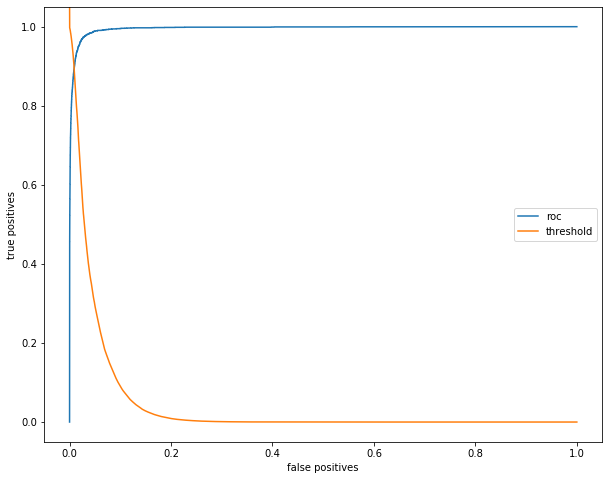

In [131]:
# Evalutation
print(">>> Computing AUC...")

from sklearn.metrics import roc_auc_score, roc_curve

pred = model.predict(X_test,batch_size=2048)
auc = roc_auc_score(y_test, pred)
print("AUC score: " + str(auc))

print(">>> Saving ROC curve...")
fp , tp, th = roc_curve(y_test, pred)
plt.plot(fp, tp, label="roc")
plt.plot(fp, th, label="threshold")
plt.xlabel("false positives")
plt.ylabel("true positives")
plt.ylim(-0.05,1.05)
plt.legend()

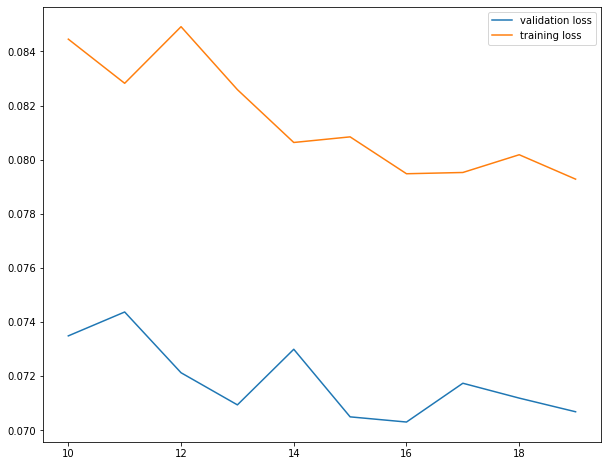

In [132]:
plt.plot(history.epoch, history.history["val_loss"], label="validation loss")
plt.plot(history.epoch, history.history["loss"], label="training loss")
plt.legend()

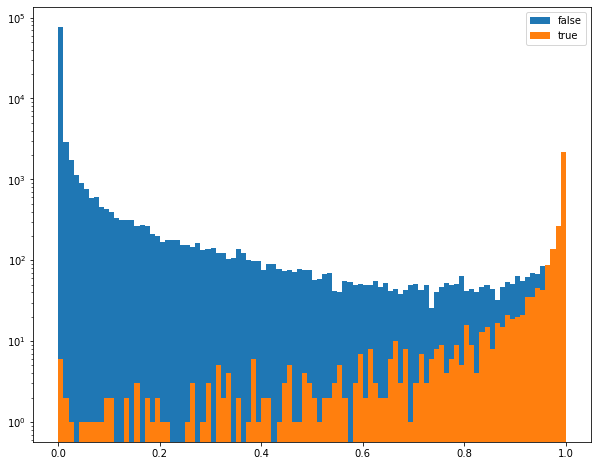

In [133]:
results = model.predict(X_test)
plt.hist(results[y_test==0], bins=100, label="false")
plt.hist(results[y_test==1], bins=100, label="true")
plt.yscale("log")
plt.legend()

# Some plots

In [134]:
data_out = data[data.in_scluster== False]
data_in = data[data.in_scluster == True]
cols = ["seed_eta", "seed_phi", "seed_iz","cluster_deta", "cluster_dphi", "en_seed", "en_cluster"]

In [135]:
data_out["y"] = model.predict(scaler.transform(data_out[cols].values), batch_size=128)
data_in["y"] = model.predict(scaler.transform(data_in[cols].values), batch_size=128)

/usr/local/bin/start_ipykernel.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/bin/start_ipykernel.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [184]:
tr = 0.95
data_out_0 = data_out[data_out.y < tr]
data_out_1 = data_out[data_out.y > tr]
data_in_0 = data_in[data_in.y < tr]
data_in_1 = data_in[data_in.y > tr]

(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 2.000e+00, 1.000e+01, 9.000e+00, 1.700e+01, 2.900e+01,
        3.900e+01, 7.000e+01, 8.000e+01, 1.730e+02, 2.540e+02, 3.700e+02,
        7.210e+02, 1.395e+03, 2.461e+03, 4.281e+03, 2.435e+03, 2.851e+03,
        4.130e+03, 2.341e+03, 1.320e+03, 7.160e+02, 4.160e+02, 2.900e+02,
        1.570e+02, 1.190e+02, 5.400e+01, 4.600e+01, 2.700e+01, 2.000e+01,
        1.300e+01, 1.300e+01, 4.000e+0

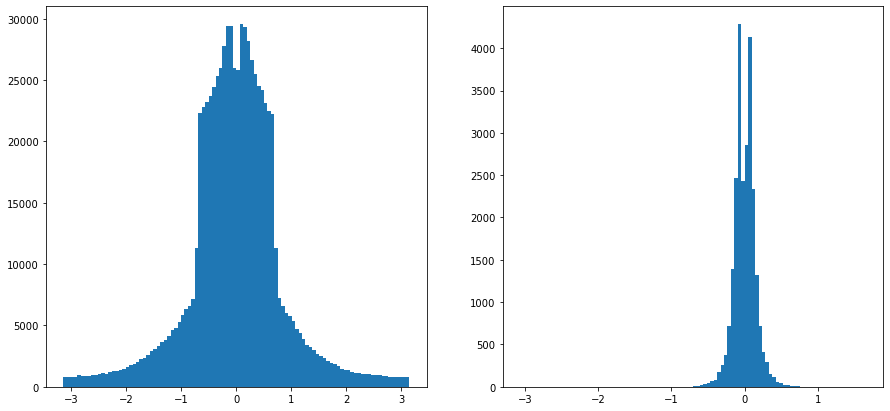

In [195]:
fig, ax = plt.subplots(1,2, figsize=(15,7))
ax[0].hist(data_out.cluster_dphi, bins=100)
ax[1].hist(data_in.cluster_dphi, bins=100)

(0, 100)

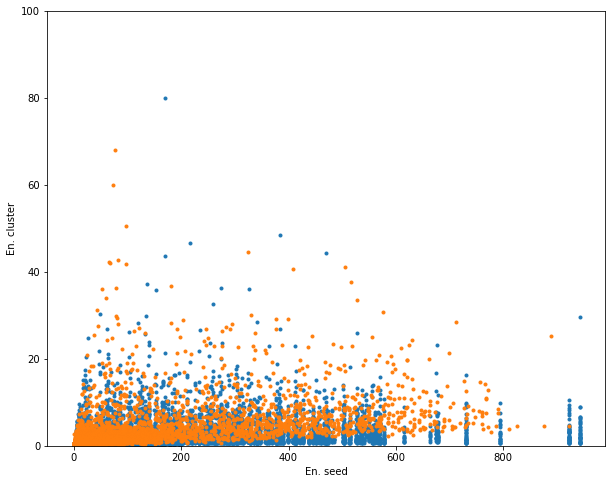

In [92]:
plt.scatter(data_out_0.en_seed, data_out_0.en_cluster, marker=".")
plt.scatter(data_out_1.en_seed, data_out_1.en_cluster, marker=".")
plt.xlabel("En. seed")
plt.ylabel("En. cluster")
plt.ylim(0, 100)

Text(0, 0.5, 'En. cluster')

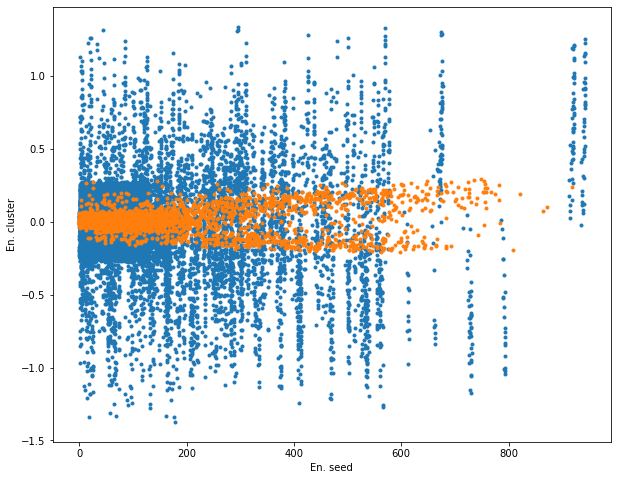

In [93]:
plt.scatter(abs(data_out_0.en_seed - data_out_0.en_cluster), data_out_0.cluster_deta, marker=".")
plt.scatter(abs(data_out_1.en_seed - data_out_1.en_cluster), data_out_1.cluster_deta,  marker=".")
plt.xlabel("En. seed")
plt.ylabel("En. cluster")

(-0.8, 0.8)

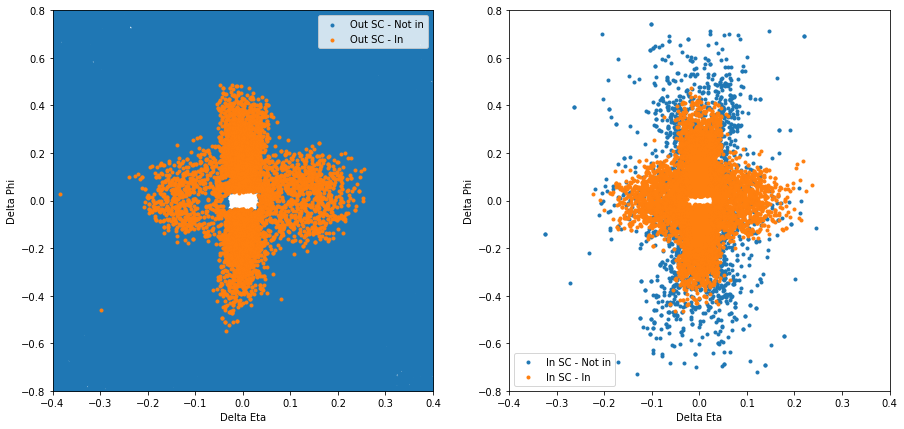

In [137]:
fig, ax = plt.subplots(1,2, figsize=(15,7))
ax[0].scatter(data_out_0.cluster_deta, data_out_0.cluster_dphi, marker=".", label="Out SC - Not in")
ax[0].scatter(data_out_1.cluster_deta, data_out_1.cluster_dphi,  marker=".", label="Out SC - In")
ax[1].scatter(data_in_0.cluster_deta, data_in_0.cluster_dphi, marker=".", label="In SC - Not in")
ax[1].scatter(data_in_1.cluster_deta, data_in_1.cluster_dphi,  marker=".", label="In SC - In")
ax[0].set_xlabel("Delta Eta")
ax[0].set_ylabel("Delta Phi")
ax[1].set_xlabel("Delta Eta")
ax[1].set_ylabel("Delta Phi")
ax[0].legend()
ax[1].legend()
ax[1].set_xlim(-0.4, 0.4)
ax[1].set_ylim(-0.8,0.8)
ax[0].set_xlim(-0.4, 0.4)
ax[0].set_ylim(-0.8,0.8)

(-0.8, 0.8)

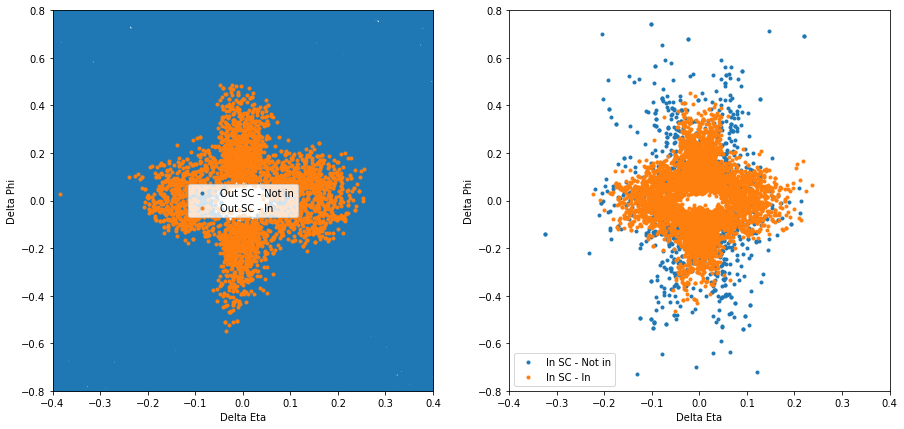

In [138]:
eta_min = 1.5
eta_max = 3
fig, ax = plt.subplots(1,2, figsize=(15,7))
ax[0].scatter(data_out_0[ (abs(data_out_0.seed_eta)> eta_min) & (abs(data_out_0.seed_eta)< eta_max) ].cluster_deta, data_out_0[ (abs(data_out_0.seed_eta)> eta_min) & (abs(data_out_0.seed_eta)< eta_max) ].cluster_dphi, marker=".", label="Out SC - Not in")
ax[0].scatter(data_out_1[ (abs(data_out_1.seed_eta)> eta_min) & (abs(data_out_1.seed_eta)< eta_max) ].cluster_deta, data_out_1[ (abs(data_out_1.seed_eta)> eta_min) & (abs(data_out_1.seed_eta)< eta_max) ].cluster_dphi,  marker=".", label="Out SC - In")
ax[1].scatter(data_in_0[ (abs(data_in_0.seed_eta)> eta_min) & (abs(data_in_0.seed_eta)< eta_max) ].cluster_deta, data_in_0[ (abs(data_in_0.seed_eta)> eta_min) & (abs(data_in_0.seed_eta)< eta_max) ].cluster_dphi, marker=".", label="In SC - Not in")
ax[1].scatter(data_in_1[ (abs(data_in_1.seed_eta)> eta_min) & (abs(data_in_1.seed_eta)< eta_max) ].cluster_deta, data_in_1[ (abs(data_in_1.seed_eta)> eta_min) & (abs(data_in_1.seed_eta)< eta_max) ].cluster_dphi,  marker=".", label="In SC - In")
ax[0].set_xlabel("Delta Eta")
ax[0].set_ylabel("Delta Phi")
ax[1].set_xlabel("Delta Eta")
ax[1].set_ylabel("Delta Phi")
ax[0].legend()
ax[1].legend()
ax[1].set_xlim(-0.4, 0.4)
ax[1].set_ylim(-0.8,0.8)
ax[0].set_xlim(-0.4, 0.4)
ax[0].set_ylim(-0.8,0.8)

(-0.8, 0.8)

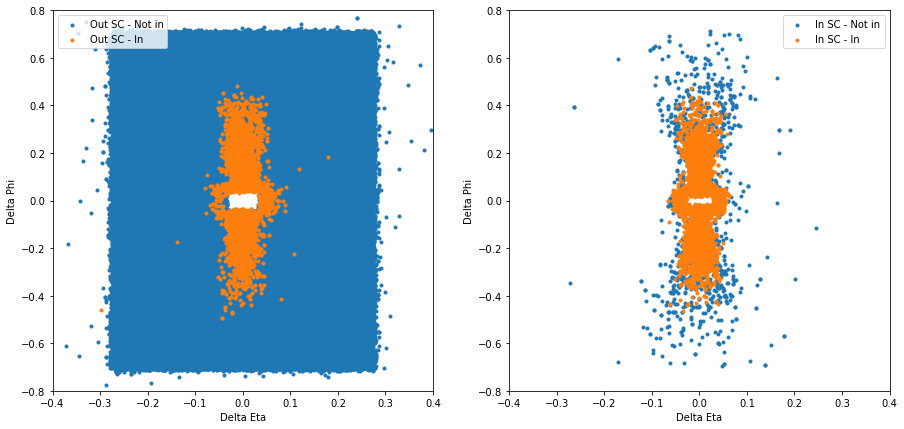

In [139]:
eta_min = 0
eta_max = 1.5
fig, ax = plt.subplots(1,2, figsize=(15,7))
ax[0].scatter(data_out_0[ (abs(data_out_0.seed_eta)> eta_min) & (abs(data_out_0.seed_eta)< eta_max) ].cluster_deta, data_out_0[ (abs(data_out_0.seed_eta)> eta_min) & (abs(data_out_0.seed_eta)< eta_max) ].cluster_dphi, marker=".", label="Out SC - Not in")
ax[0].scatter(data_out_1[ (abs(data_out_1.seed_eta)> eta_min) & (abs(data_out_1.seed_eta)< eta_max) ].cluster_deta, data_out_1[ (abs(data_out_1.seed_eta)> eta_min) & (abs(data_out_1.seed_eta)< eta_max) ].cluster_dphi,  marker=".", label="Out SC - In")
ax[1].scatter(data_in_0[ (abs(data_in_0.seed_eta)> eta_min) & (abs(data_in_0.seed_eta)< eta_max) ].cluster_deta, data_in_0[ (abs(data_in_0.seed_eta)> eta_min) & (abs(data_in_0.seed_eta)< eta_max) ].cluster_dphi, marker=".", label="In SC - Not in")
ax[1].scatter(data_in_1[ (abs(data_in_1.seed_eta)> eta_min) & (abs(data_in_1.seed_eta)< eta_max) ].cluster_deta, data_in_1[ (abs(data_in_1.seed_eta)> eta_min) & (abs(data_in_1.seed_eta)< eta_max) ].cluster_dphi,  marker=".", label="In SC - In")
ax[0].set_xlabel("Delta Eta")
ax[0].set_ylabel("Delta Phi")
ax[1].set_xlabel("Delta Eta")
ax[1].set_ylabel("Delta Phi")
ax[0].legend()
ax[1].legend()
ax[1].set_xlim(-0.4, 0.4)
ax[1].set_ylim(-0.8,0.8)
ax[0].set_xlim(-0.4, 0.4)
ax[0].set_ylim(-0.8,0.8)

(-0.6, 0.6)

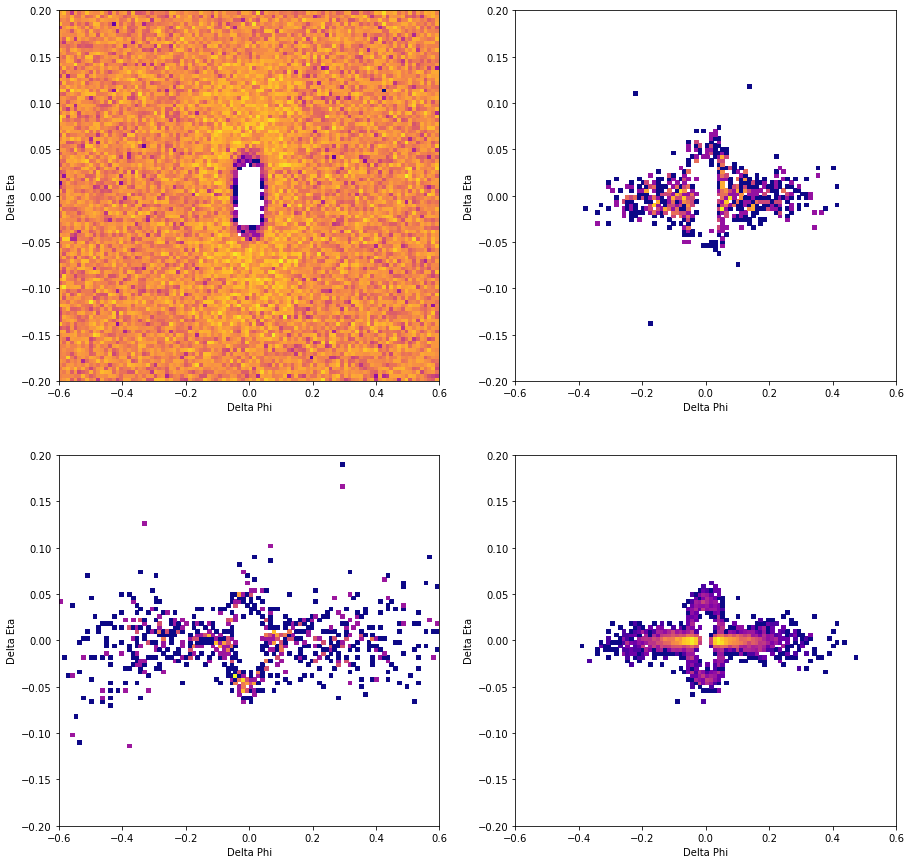

In [190]:
eta_min = 0
eta_max = 1
nbins = 100
fig, ax = plt.subplots(2,2, figsize=(15,15))
ax[0][0].hist2d(data_out_0[ (abs(data_out_0.seed_eta)> eta_min) & (abs(data_out_0.seed_eta)< eta_max) ].cluster_dphi, 
                data_out_0[ (abs(data_out_0.seed_eta)> eta_min) & (abs(data_out_0.seed_eta)< eta_max) ].cluster_deta,
                density=True, bins=(nbins,nbins), range=((-0.6,0.6),(-0.2,0.2)), cmap="plasma", norm=colors.LogNorm())
ax[0][1].hist2d(data_out_1[ (abs(data_out_1.seed_eta)> eta_min) & (abs(data_out_1.seed_eta)< eta_max) ].cluster_dphi, 
                data_out_1[ (abs(data_out_1.seed_eta)> eta_min) & (abs(data_out_1.seed_eta)< eta_max) ].cluster_deta,  
                density=True, bins=(nbins,nbins), range=((-0.6,0.6),(-0.2,0.2)), cmap="plasma", norm=colors.LogNorm())
ax[1][0].hist2d(data_in_0[ (abs(data_in_0.seed_eta)> eta_min) & (abs(data_in_0.seed_eta)< eta_max) ].cluster_dphi, 
                data_in_0[ (abs(data_in_0.seed_eta)> eta_min) & (abs(data_in_0.seed_eta)< eta_max) ].cluster_deta,  
                density=True, bins=(nbins,nbins), range=((-0.6,0.6),(-0.2,0.2)), cmap="plasma", norm=colors.LogNorm())
ax[1][1].hist2d(data_in_1[ (abs(data_in_1.seed_eta)> eta_min) & (abs(data_in_1.seed_eta)< eta_max) ].cluster_dphi, 
                data_in_1[ (abs(data_in_1.seed_eta)> eta_min) & (abs(data_in_1.seed_eta)< eta_max) ].cluster_deta,   
                density=True, bins=(nbins,nbins), range=((-0.6,0.6),(-0.2,0.2)), cmap="plasma", norm=colors.LogNorm())
ax[0][0].set_ylabel("Delta Eta")
ax[0][0].set_xlabel("Delta Phi")
ax[1][0].set_ylabel("Delta Eta")
ax[1][0].set_xlabel("Delta Phi")
ax[0][1].set_ylabel("Delta Eta")
ax[0][1].set_xlabel("Delta Phi")
ax[1][1].set_ylabel("Delta Eta")
ax[1][1].set_xlabel("Delta Phi")

ax[1][0].set_ylim(-0.2, 0.2)
ax[1][0].set_xlim(-0.6,0.6)
ax[0][0].set_ylim(-0.2, 0.2)
ax[0][0].set_xlim(-0.6,0.6)
ax[1][1].set_ylim(-0.2, 0.2)
ax[1][1].set_xlim(-0.6,0.6)
ax[0][1].set_ylim(-0.2, 0.2)
ax[0][1].set_xlim(-0.6,0.6)

(-0.6, 0.6)

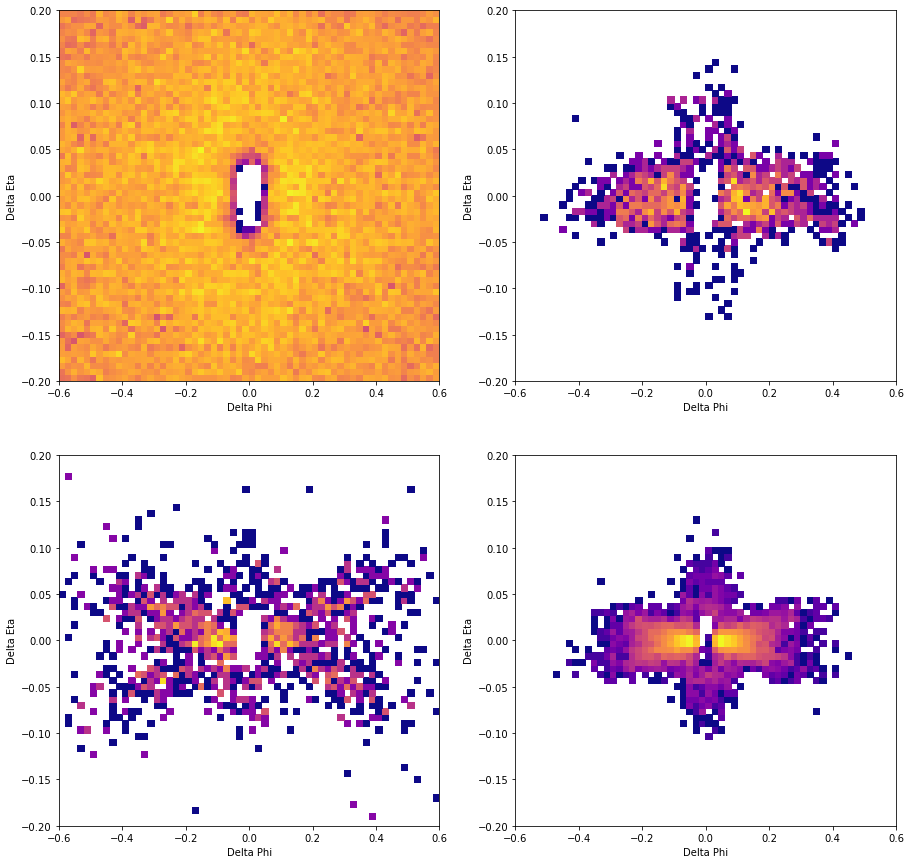

In [189]:
eta_min = 1
eta_max = 2
nbins = 60
fig, ax = plt.subplots(2,2, figsize=(15,15))
ax[0][0].hist2d(data_out_0[ (abs(data_out_0.seed_eta)> eta_min) & (abs(data_out_0.seed_eta)< eta_max) ].cluster_dphi, 
                data_out_0[ (abs(data_out_0.seed_eta)> eta_min) & (abs(data_out_0.seed_eta)< eta_max) ].cluster_deta,
                density=True, bins=(nbins,nbins), range=((-0.6,0.6),(-0.2,0.2)), cmap="plasma", norm=colors.LogNorm())
ax[0][1].hist2d(data_out_1[ (abs(data_out_1.seed_eta)> eta_min) & (abs(data_out_1.seed_eta)< eta_max) ].cluster_dphi, 
                data_out_1[ (abs(data_out_1.seed_eta)> eta_min) & (abs(data_out_1.seed_eta)< eta_max) ].cluster_deta,  
                density=True, bins=(nbins,nbins), range=((-0.6,0.6),(-0.2,0.2)), cmap="plasma", norm=colors.LogNorm())
ax[1][0].hist2d(data_in_0[ (abs(data_in_0.seed_eta)> eta_min) & (abs(data_in_0.seed_eta)< eta_max) ].cluster_dphi, 
                data_in_0[ (abs(data_in_0.seed_eta)> eta_min) & (abs(data_in_0.seed_eta)< eta_max) ].cluster_deta,  
                density=True, bins=(nbins,nbins), range=((-0.6,0.6),(-0.2,0.2)), cmap="plasma", norm=colors.LogNorm())
ax[1][1].hist2d(data_in_1[ (abs(data_in_1.seed_eta)> eta_min) & (abs(data_in_1.seed_eta)< eta_max) ].cluster_dphi, 
                data_in_1[ (abs(data_in_1.seed_eta)> eta_min) & (abs(data_in_1.seed_eta)< eta_max) ].cluster_deta,   
                density=True, bins=(nbins,nbins), range=((-0.6,0.6),(-0.2,0.2)), cmap="plasma", norm=colors.LogNorm())
ax[0][0].set_ylabel("Delta Eta")
ax[0][0].set_xlabel("Delta Phi")
ax[1][0].set_ylabel("Delta Eta")
ax[1][0].set_xlabel("Delta Phi")
ax[0][1].set_ylabel("Delta Eta")
ax[0][1].set_xlabel("Delta Phi")
ax[1][1].set_ylabel("Delta Eta")
ax[1][1].set_xlabel("Delta Phi")

ax[1][0].set_ylim(-0.2, 0.2)
ax[1][0].set_xlim(-0.6,0.6)
ax[0][0].set_ylim(-0.2, 0.2)
ax[0][0].set_xlim(-0.6,0.6)
ax[1][1].set_ylim(-0.2, 0.2)
ax[1][1].set_xlim(-0.6,0.6)
ax[0][1].set_ylim(-0.2, 0.2)
ax[0][1].set_xlim(-0.6,0.6)

(-0.6, 0.6)

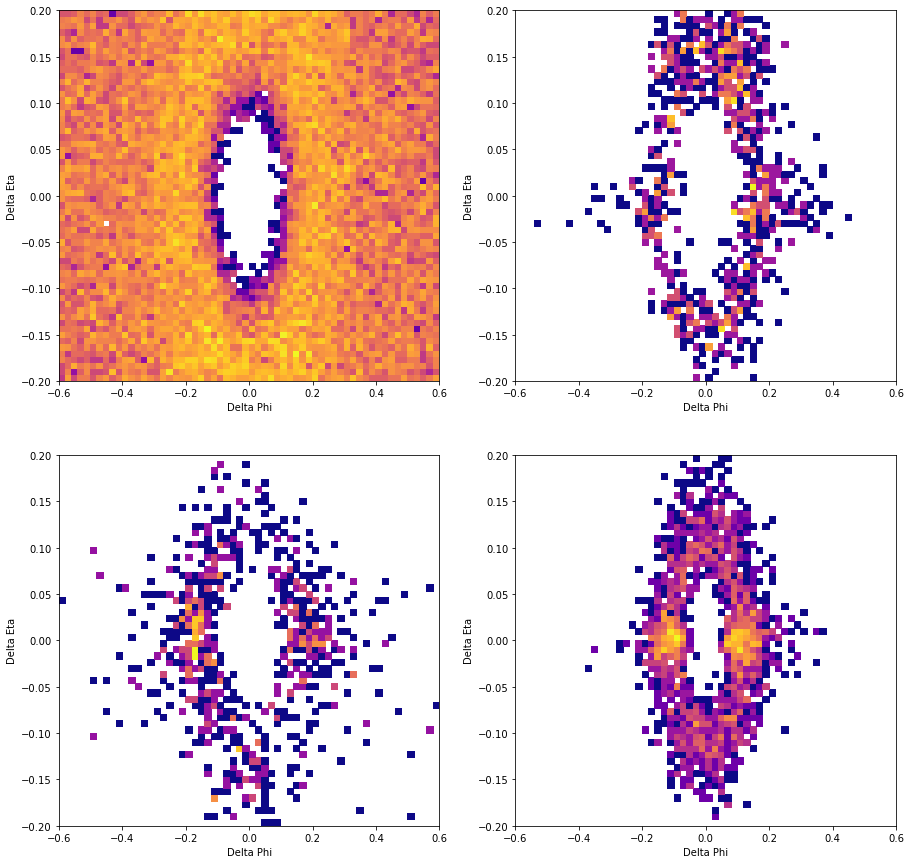

In [191]:
eta_min = 2
eta_max = 3
nbins = 60
fig, ax = plt.subplots(2,2, figsize=(15,15))
ax[0][0].hist2d(data_out_0[ (abs(data_out_0.seed_eta)> eta_min) & (abs(data_out_0.seed_eta)< eta_max) ].cluster_dphi, 
                data_out_0[ (abs(data_out_0.seed_eta)> eta_min) & (abs(data_out_0.seed_eta)< eta_max) ].cluster_deta,
                density=True, bins=(nbins,nbins), range=((-0.6,0.6),(-0.2,0.2)), cmap="plasma", norm=colors.LogNorm())
ax[0][1].hist2d(data_out_1[ (abs(data_out_1.seed_eta)> eta_min) & (abs(data_out_1.seed_eta)< eta_max) ].cluster_dphi, 
                data_out_1[ (abs(data_out_1.seed_eta)> eta_min) & (abs(data_out_1.seed_eta)< eta_max) ].cluster_deta,  
                density=True, bins=(nbins,nbins), range=((-0.6,0.6),(-0.2,0.2)), cmap="plasma", norm=colors.LogNorm())
ax[1][0].hist2d(data_in_0[ (abs(data_in_0.seed_eta)> eta_min) & (abs(data_in_0.seed_eta)< eta_max) ].cluster_dphi, 
                data_in_0[ (abs(data_in_0.seed_eta)> eta_min) & (abs(data_in_0.seed_eta)< eta_max) ].cluster_deta,  
                density=True, bins=(nbins,nbins), range=((-0.6,0.6),(-0.2,0.2)), cmap="plasma", norm=colors.LogNorm())
ax[1][1].hist2d(data_in_1[ (abs(data_in_1.seed_eta)> eta_min) & (abs(data_in_1.seed_eta)< eta_max) ].cluster_dphi, 
                data_in_1[ (abs(data_in_1.seed_eta)> eta_min) & (abs(data_in_1.seed_eta)< eta_max) ].cluster_deta,   
                density=True, bins=(nbins,nbins), range=((-0.6,0.6),(-0.2,0.2)), cmap="plasma", norm=colors.LogNorm())
ax[0][0].set_ylabel("Delta Eta")
ax[0][0].set_xlabel("Delta Phi")
ax[1][0].set_ylabel("Delta Eta")
ax[1][0].set_xlabel("Delta Phi")
ax[0][1].set_ylabel("Delta Eta")
ax[0][1].set_xlabel("Delta Phi")
ax[1][1].set_ylabel("Delta Eta")
ax[1][1].set_xlabel("Delta Phi")

ax[1][0].set_ylim(-0.2, 0.2)
ax[1][0].set_xlim(-0.6,0.6)
ax[0][0].set_ylim(-0.2, 0.2)
ax[0][0].set_xlim(-0.6,0.6)
ax[1][1].set_ylim(-0.2, 0.2)
ax[1][1].set_xlim(-0.6,0.6)
ax[0][1].set_ylim(-0.2, 0.2)
ax[0][1].set_xlim(-0.6,0.6)